In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from scipy import signal
import h5py

def MagModel(n_channel, coordinates, roll=-14):
    ant_angles = np.arange(0, 360, 360//n_channel)

    x_array = 0.1 * np.cos(np.radians(ant_angles))
    y_array = 0.1 * np.sin(np.radians(ant_angles))
    x_coord, y_coord = coordinates[:, 0], coordinates[:, 1]
    
    d0 = 0.1
    wavelength = 0.0116

    d = np.sqrt(
        (x_array[:, np.newaxis] - x_coord[np.newaxis, :]) ** 2
        + (y_array[:, np.newaxis] - y_coord[np.newaxis, :]) ** 2
        )
    
    relative_mag = wavelength/d
    
    return relative_mag ** 1

def error_corrector(array, error_list):
    for i in range(len(error_list)):
        array[error_list[i]] = (array[error_list[i]-1] + array[error_list[i]+1]) / 2
    return array



In [18]:
data_repo = Path.home()/'group'/'project'/'datasets'/'data'/'230412_jugaad_analysis'

synth_data = '221230_synca1_5slot_scan_fft.npy'
synth_data = np.load(data_repo/synth_data)
synth_data = np.roll(synth_data, 60, axis=2)

jugaad_data = data_repo/'230412_jugaad_data.h5'
jugaad_data = h5py.File(jugaad_data, 'r')
test_key = 'r00z00'
test_data = jugaad_data[test_key][:]

synth_error_dict = {
    0:{
        0:[6,33,77,102],1:[61],2:[19],3:[10,35,71,87,117],4:[35,44,63,116],5:[107],6:[],7:[]
    },
}



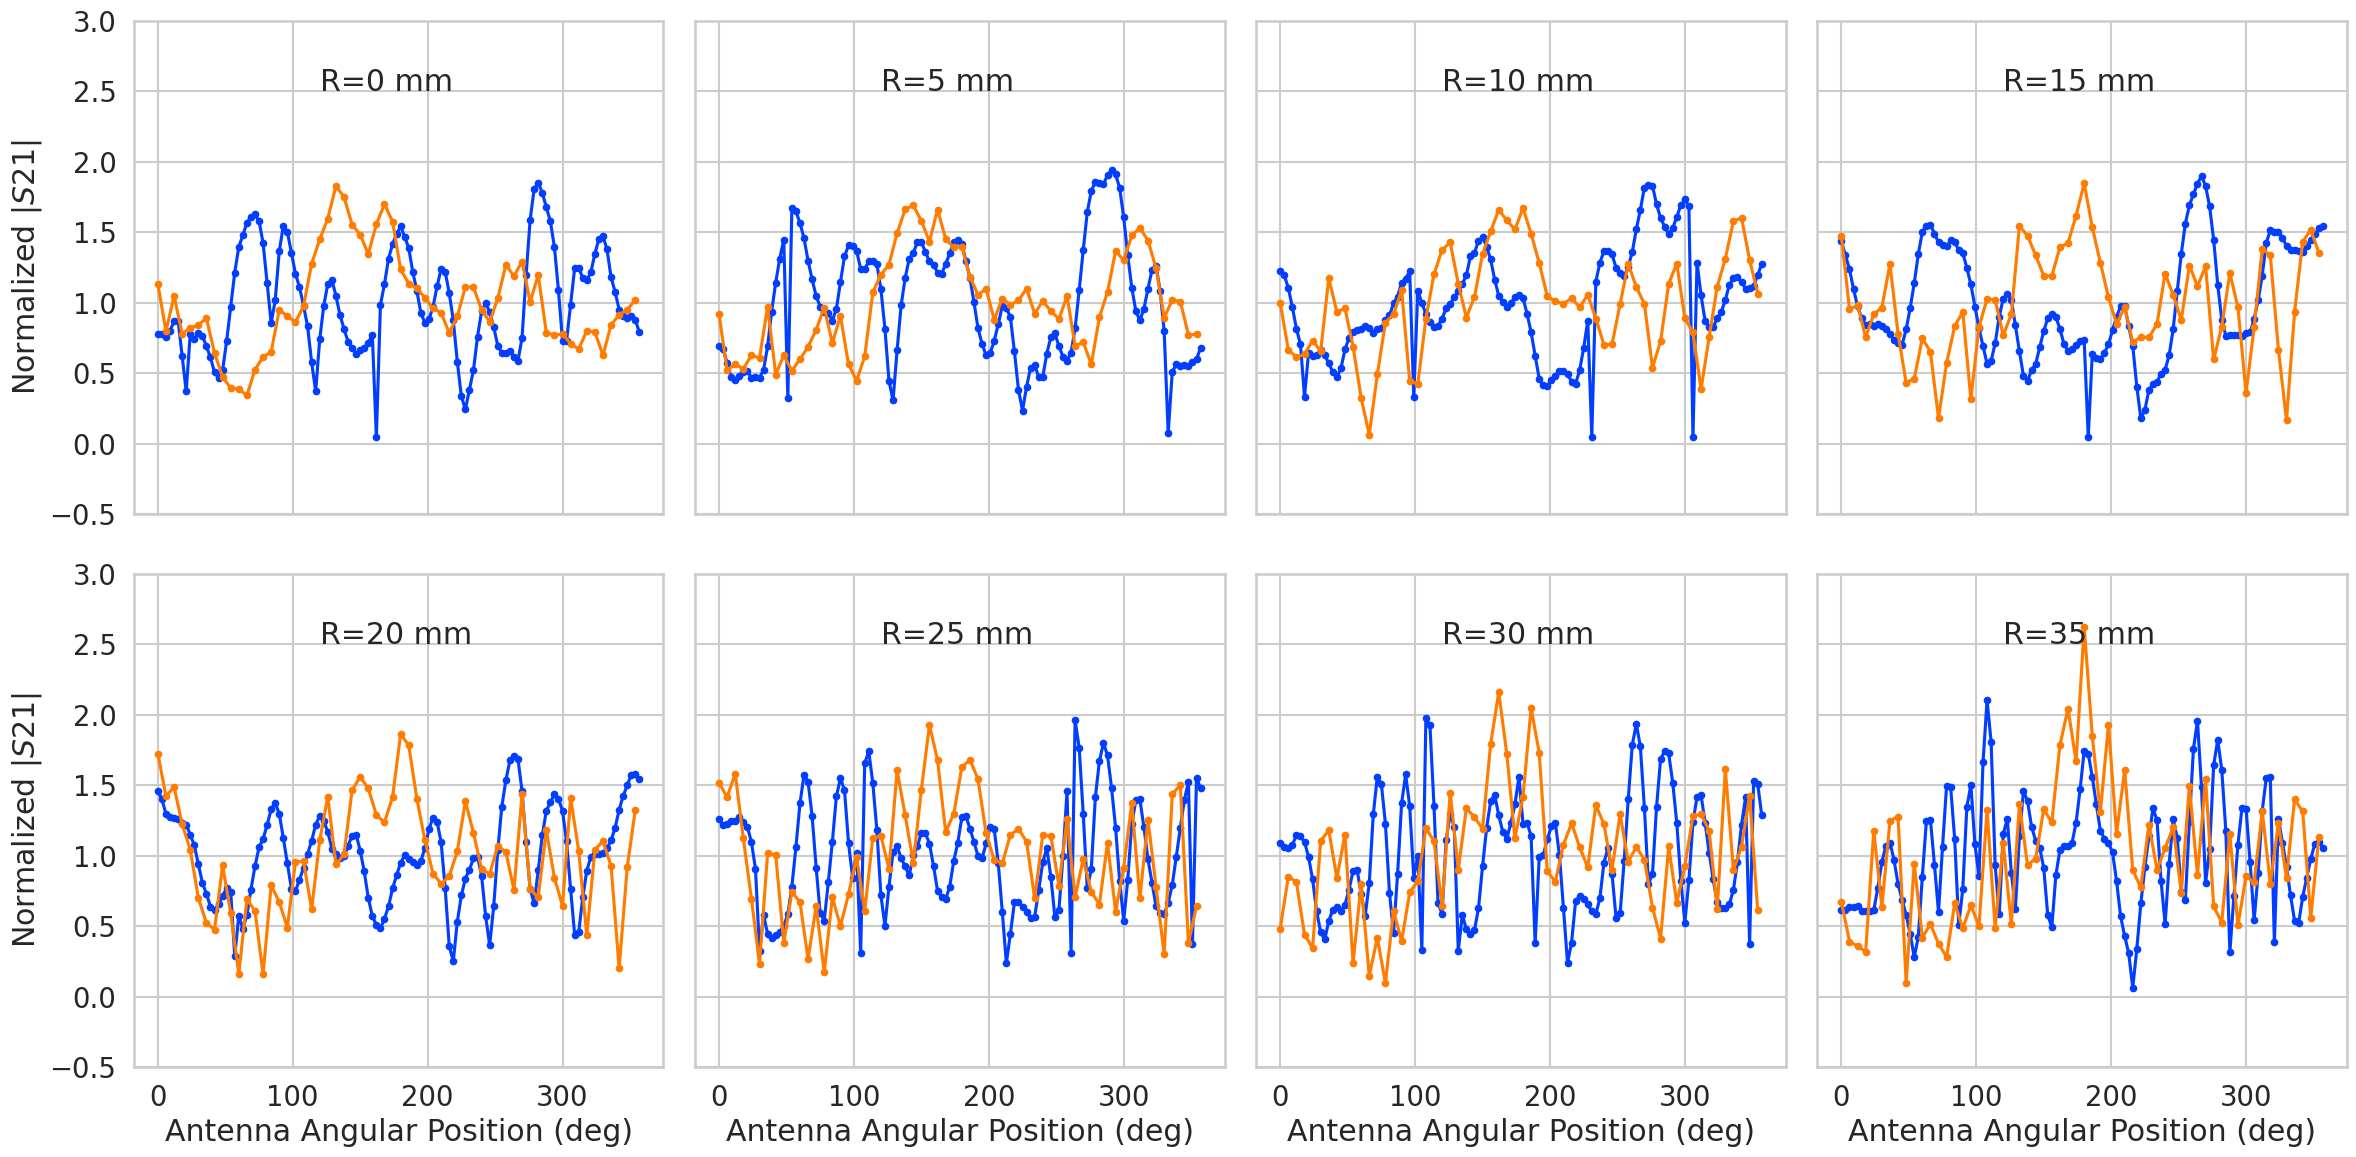

In [29]:
#fig,axs = plt.subplots(2,4,sharex=False,sharey=False,figsize=(40,16))
sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
fig,axs = plt.subplots(2,4,sharex=True,sharey=True,figsize=(24,12))
axs = axs.flatten()
#fig = plt.figure(figsize=(13,8))
#ax = fig.add_subplot(1,1,1)
clist = sns.color_palette('bright')

for m,test_z in enumerate(['00',]):
    
    for n,r in enumerate(np.arange(0,40,5)):
        if r < 10:
            key = f'r0{r}z{test_z}'
        else:
            key = f'r{r}z{test_z}'
        temp_data = jugaad_data[key][:]
        mags_ju = np.roll(abs(temp_data[:,70,0,1]),-15)
        mags_ju = mags_ju / np.mean(mags_ju) # rescale
        #mags_ju = mags_ju - np.mean(mags_ju) # remove DC
        
        mags_syn = abs(synth_data[m,n,:,1])
        mags_syn = error_corrector(mags_syn, synth_error_dict[m][n])
        mags_syn = mags_syn / np.mean(mags_syn) # rescale
        #mags_ju = mags_ju - np.mean(mags_ju) # remove DC
        
        axs[n].plot(
            np.arange(0,360,3),
            np.convolve(mags_syn, np.ones(1)/1, mode='valid'),
            color=clist[0],
            ls='-',
            marker='.',
            
        )
        axs[n].plot(
            np.arange(0,360,6),
            mags_ju,
            color=clist[1],
            marker='.',
            ls='-',
        )
        #axs[i].set_xlim(0,120)
        
        if n%4==0:
            axs[n].set_ylabel(r'Normalized $|S21|$')
        if n>3:
            axs[n].set_xlabel('Antenna Angular Position (deg)')
        axs[n].set_ylim(-0.5, 3)
        axs[n].text(120,2.5,f'R={r} mm')
        
plt.tight_layout(pad=1.05)
name = '230412_jugaad_mag_curves_z0'
plt.savefig(Path.home()/'group'/'project'/'plots'/name, dpi=150)



